In [65]:
from analyze_language_change import Mail, Paper, import_corpus, linear_prediction, occurrence_freq_by_year, occurrences_by_year, plot_word_timeseries
from pydantic import TypeAdapter
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np 
import spacy

In [66]:
corpus_12_25 = import_corpus(batch_size=100, streaming=False, url="julilili42/tagesschau")
uni_mails = import_corpus(batch_size=100, streaming=False, url="DerSandmannHD/Uni-Mail", adapter = TypeAdapter(list[Mail]))
papers = import_corpus(batch_size=100, streaming=False, url="julilili42/papers", adapter = TypeAdapter(list[Paper]))

In [64]:
rows = [(a.date.year, a.article) for a in papers]
year, articles = zip(*rows)

10510 articles to be loaded for dataset papers


In [50]:
# distribution of articles for years
year_distribution = pd.Series(year).value_counts().sort_index()
# generate word matrix 
vec = CountVectorizer(max_features=100000, binary=True)
word_matrix_bin = vec.fit_transform(articles)
vocab = vec.get_feature_names_out()

Text(0, 0.5, 'Number of articles')

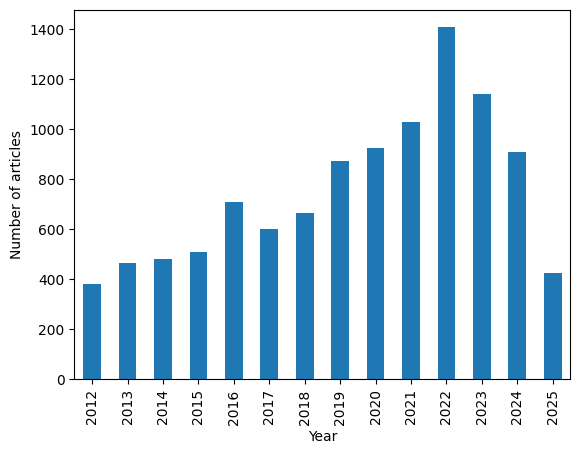

In [51]:
ax = year_distribution.plot(kind="bar")
ax.set_xlabel("Year")
ax.set_ylabel("Number of articles")

In [52]:
occurence_freq = occurrence_freq_by_year(year=year, word_matrix_bin=word_matrix_bin, vocab=vocab)
occurence_counts = occurrences_by_year(year=year, word_matrix=word_matrix_bin, vocab=vocab)

Goal: try to find words which disproportionaly increased in use, by interpolating use in year 2024 

- frequency gap $\delta = p - q$ $\implies$ highlights excess usage of frequent words
- frequency ratio $r = \frac{p}{q}$ $\implies$ highlights excess usage of infrequent words.

In [53]:
eps = 1e-6

# dataframe containing frequencies before introduction of llm's
train = occurence_freq.loc[2020:2022]
train_baseline = train.mean()

# empirical frequency
p = occurence_freq.loc[2024] 

# absolute growth from baseline in percent
growth_abs = (p - train_baseline) / (train_baseline + eps)
growth_log = np.log((p + eps) / (train_baseline + eps))

# linear interpolation, frequency value of 2024
q = train.apply(linear_prediction, axis=0)

# Metric 1: frequency gap delta = p - q
delta = p - q

# Metric 2: frequency ratio r = p/q
min_q = 5e-4
min_p = 5e-3
mask = (q > min_q) & (p > min_p)
r = p[mask] / q[mask]

sorted_freq_gap = delta.sort_values(ascending=False).head(20)
sorted_freq_ratio = r.sort_values(ascending=False).head(50)

sorted_freq_mean = growth_log.sort_values(ascending=False).head(20)
sorted_freq_mean

forcings           9.084923
chatgpt            8.614987
1850               8.614987
hvc                8.614987
graphite           8.614987
magnocellular      8.614987
2025               8.614987
drier              8.614987
wetter             8.614987
undersampling      8.614987
avalanches         8.614987
proliferative      8.614987
millennia          8.614987
birdsong           8.391889
warmth             8.391889
omission           8.391889
electrochemical    8.391889
72076              8.391889
omitted            8.391889
cyclones           8.391889
dtype: float64

In [54]:
metrics = pd.DataFrame({"p": p, "q": q, "growth": growth_log})

metrics["delta"] = metrics["p"] - metrics["q"]
metrics["r"] = metrics["p"] / np.maximum(metrics["q"], eps)

mask_ratio = (metrics["q"] > min_q) & (metrics["p"] > min_p)
excess = metrics.loc[mask_ratio]

In [55]:
import spacy
# german    de_core_news_lg
# english   en_core_web_lg
nlp = spacy.load("en_core_web_lg")

words = list(excess.index)
pos_tags = {}
for doc in nlp.pipe(words, batch_size=500):
    token = doc[0]
    pos_tags[token.text] = token.pos_

allowed_pos = {"ADJ", "VERB"}
style_words = [w for w, pos in pos_tags.items() if pos in allowed_pos]

excess_style_words = excess.loc[excess.index.isin(style_words)].sort_values("growth", ascending=False)

In [56]:
excess_style_words

,p,q,growth,delta,r
clonal,0.007718,0.144959,3.478804,-0.137242,0.053241
hydroclimate,0.006615,0.144959,3.324675,-0.138344,0.045635
contentheadercolor,0.015436,0.857100,2.960218,-0.841664,0.018009
decadal,0.007718,0.376925,2.787760,-0.369207,0.020476
lgm,0.005513,0.376925,2.451339,-0.371412,0.014625
...,...,...,...,...,...
constant,0.008820,0.019361,-0.903355,-0.010541,0.455571
em,0.007718,0.021306,-0.921411,-0.013588,0.362233
reach,0.005513,0.007399,-0.939227,-0.001886,0.745082
combines,0.005513,0.011292,-1.060510,-0.005780,0.488177


In [57]:
llm_words_de = {
    "jedoch", "insbesondere", "beispielsweise", "weiterhin", "somit", "letztlich",
    "zugleich", "daraufhin", "entsprechend", "vermutlich", "wahrscheinlich",
    "insgesamt", "relevant", "bedeutend", "entscheidend", "zudem", "grundsätzlich",
    "dennoch", "außerdem", "daher", "deshalb", "dementsprechend", "trotzdem",
    "folglich", "anschließend", "vor allem", "darunter", "ferner", "vorher",
    "aktuell", "anschließend", "anschließend", "bisher", "zuvor", "anschließend",
    "künftig", "ebenso", "hingegen", "beachtlich", "wesentlich", "notwendig",
    "gegebenenfalls", "typischerweise", "häufig", "gelegentlich", "zumeist",
    "oftmals", "grundlegend", "relevant", "weshalb", "demnach", "somit",
    "dementsprechend", "beachtenswert", "überdies", "hinreichend", "wesentlicher",
    "prägnant", "effektiv", "effizient", "weshalb", "sowohl", "einerseits",
    "andererseits"
}


llm_words_en = {
    "however", "therefore", "thus", "moreover", "furthermore", "additionally",
    "consequently", "hence", "overall", "notably", "significantly", "indeed",
    "particularly", "specifically", "typically", "generally", "commonly",
    "frequently", "importantly", "essentially", "fundamentally", "crucially",
    "ultimately", "accordingly", "meanwhile", "subsequently", "nevertheless",
    "nonetheless", "similarly", "likewise", "additionally", 
    "arguably", "notably", "remarkably", "clearly", "evidently", "apparently",
    "presumably", "undoubtedly", "likely", "probably", "potentially",
    "essential", "necessary", "relevant", "important", "key", "central",
    "crucial", "significant", "primary", "major", "critical", "noteworthy",
    "overall", "eventually", "ultimately", "consequently", "henceforth",
    "simultaneously", "meanwhile", "previously", "subsequently", "formerly", 
    "currently", "nowadays",
}


found_llm_words = [w for w in llm_words_en if w in excess.index]

llm_in_df = excess.loc[excess.index.isin(found_llm_words)]

llm_in_df.sort_values("delta", ascending=False)

,p,q,growth,delta,r
significant,0.142227,0.053770,0.448349,0.088457,2.645081
crucial,0.074972,0.028443,0.633542,0.046529,2.635869
previously,0.063947,0.020392,0.490218,0.043555,3.135845
essential,0.058434,0.020690,0.516057,0.037744,2.824255
significantly,0.109151,0.071863,0.419506,0.037288,1.518880
however,0.273429,0.249748,0.038349,0.023681,1.094820
primary,0.040794,0.017757,0.246277,0.023037,2.297348
additionally,0.059537,0.036577,0.413044,0.022960,1.627697
notably,0.028666,0.008439,0.894051,0.020227,3.396780
therefore,0.082690,0.062738,-0.027224,0.019952,1.318025


/Users/julian/Desktop/language-change/src/analyze_language_change.py:151: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(t) for t in ax.get_xticks()])


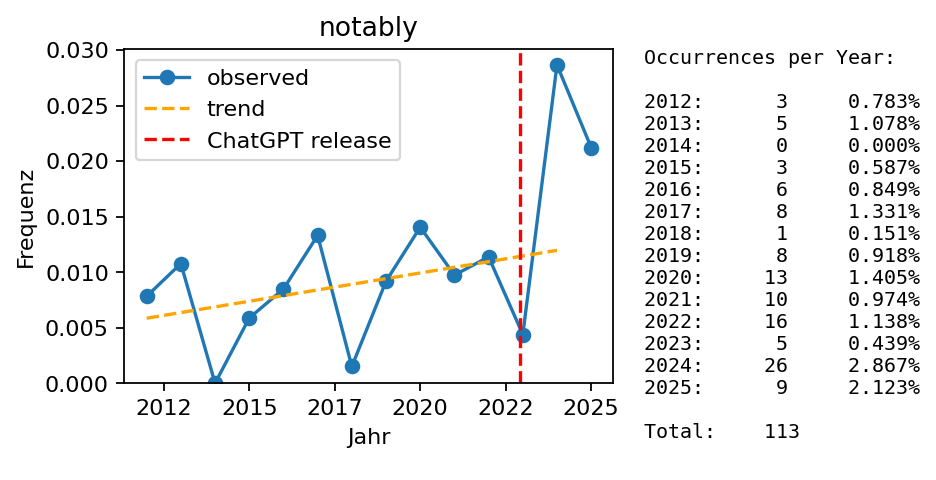

{'p': 0.02866593164277839,
 'q': 0.027796430050292278,
 'delta': 0.0008695015924861139}

In [58]:
plot_word_timeseries(
  word="notably", 
  occurence_freq=occurence_freq,
  occurrences_abs=occurence_counts,
  train_years=(2012, 2020),  #needs to adapted depending on corpus
  target_year=2024
)

sentence length

In [ ]:
nlp = spacy.load("en_core_web_lg", disable=["ner", "parser", "lemmatizer"])
nlp.add_pipe("sentencizer")  

sentence_lengths = []
sentence_years = []

for y, text in rows:
    doc = nlp(text)
    for sent in doc.sents:
        words = [t.text for t in sent if t.is_alpha]
        if len(words) > 0:
            sentence_lengths.append(len(words))
            sentence_years.append(y)

df_len = pd.DataFrame({"year": sentence_years, "length": sentence_lengths})
mean_len_per_year = df_len.groupby("year")["length"].mean()


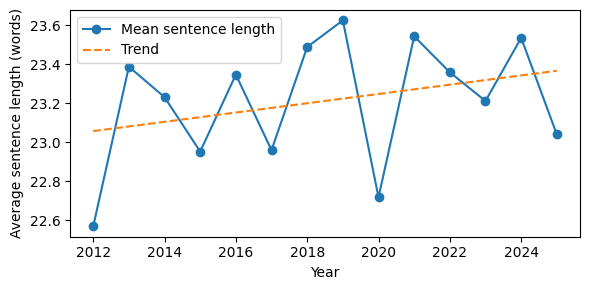

In [ ]:
import matplotlib.pyplot as plt
from numpy.polynomial import Polynomial

years = mean_len_per_year.index.values
vals = mean_len_per_year.values

pfit = Polynomial.fit(years, vals, 1)
trend = pfit(years)

plt.figure(figsize=(6,3))
plt.plot(years, vals, marker="o", label="Mean sentence length")
plt.plot(years, trend, "--", label="Trend")
plt.xlabel("Year")
plt.ylabel("Average sentence length (words)")
plt.legend()
plt.tight_layout()
plt.show()